First unzip the model configuration data in the folder models.

# Install and import relevant libraries

In [ ]:
source_folder = '/data'
destination_folder = '/models'

In [ ]:
!pip install transformers[sentencepiece]
!pip install datasets

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 22.5 MB/s 
     |████████████████████████████████| 895 kB 63.0 MB/s 
     |████████████████████████████████| 6.8 MB 49.1 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 311 kB 1.5 MB/s 
     |████████████████████████████████| 133 kB 52.2 MB/s 
     |████████████████████████████████| 1.1 MB 59.4 MB/s 
     |████████████████████████████████| 243 kB 71.2 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 47.8 MB/s 
     |████████████████████████████████| 144 kB 64.7 MB/s 


In [ ]:
from datasets import Dataset, DatasetDict, load_dataset, load_metric
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding, TrainingArguments, Trainer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load dataset from CSV and downsample data to balance sarcastic and non-sarcastic comments in training set (only run if data is not yet sampled).

In [ ]:
dataset = load_dataset('csv', data_files=source_folder+'/sarc_subset.csv', sep='|')['train'].train_test_split(0.1, seed=442)
df = pd.read_csv(filepath_or_buffer=source_folder+'/sarc_subset.csv', sep='|')
train, test = train_test_split(df, test_size=0.01, random_state=42, stratify=df['is_sarc'], shuffle=True)
dataset['train'] = Dataset.from_pandas(train, preserve_index=False)
dataset['test'] = Dataset.from_pandas(test, preserve_index=False)
test.to_csv(path_or_buf=source_folder+'/sampled_test.csv', index=False)

In [ ]:
dataset.set_format('pandas')
df = dataset['train'][:]
pids=df.parent_id.unique()
sampled=pd.DataFrame()
for i in pids:
    #keep the campaign we want to sample
    z=df.query(f'parent_id=="{i}"')
     
    A=z[z['is_sarc']==0][['is_sarc']]
    B=z[z['is_sarc']==1][['is_sarc']]
 
    #find out which is the Minority and Majority
    if len(A)>len(B):
        majority=A
        minority=B
    else:
        majority=B
        minority=A
         
    #Sampling
    indexes=majority.sample(len(minority),random_state=7).index
    #what we did here is to get the indexes that are NOT in the sampling above
    #so we can remove them in the following steps from our dataframe z
    indexes=majority.loc[~majority.index.isin(indexes)].index
     
     
    z2=z.loc[~z.index.isin(indexes)]
    sampled=pd.concat([sampled,z2])
    df=df.loc[~df.index.isin(z.index)]
sampled.to_csv(path_or_buf=source_folder+'/sampled_train.csv', index=False)

In [ ]:
df = dataset['test'][:]
pids=df.parent_id.unique()
sampled=pd.DataFrame()
for i in pids:
    #keep the campaign we want to sample
    print(len(df))
    z=df.query(f'parent_id=="{i}"')
     
    A=z[z['is_sarc']==0][['is_sarc']]
    B=z[z['is_sarc']==1][['is_sarc']]
 
    #find out which is the Minority and Majority
    if len(A)>len(B):
        majority=A
        minority=B
        #Sampling
        indexes=majority.sample(len(minority),random_state=7).index
    #what we did here is to get the indexes that are NOT in the sampling above
    #so we can remove them in the following steps from our dataframe z
        indexes=majority.loc[~majority.index.isin(indexes)].index
        z2=z.loc[~z.index.isin(indexes)]
    else:
        majority=B
        minority=A
        z2=z

     
    
    sampled=pd.concat([sampled,z2])
    df=df.loc[~df.index.isin(z.index)]
sampled.to_csv(path_or_buf=source_folder+'/balanced_test.csv', index=False)

# If downsampling was already done, just import sampled dataset.

In [ ]:
dataset = load_dataset('csv', data_files={'train': source_folder+'/sampled_train.csv', 'test': source_folder+'/sampled_test.csv'}, sep=',')
dataset = dataset.rename_column("is_sarc", "labels")
#dataset_clean = dataset.remove_columns(['post_id', 'parent_id', 'comment_id', 'subreddit'])

Using custom data configuration default-eaa85091f0b0c621


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-eaa85091f0b0c621/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Set checkpoint to import desired model for training.

In [ ]:
#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
#checkpoint = "microsoft/mpnet-base"
#checkpoint = destination_folder+"/distilbert"
checkpoint = destination_folder+"/mpnet"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Define tokenizer and metrics functions

In [ ]:
def tokenize_function(sentence):
    return tokenizer(sentence["comment"], truncation=True, padding=True)

In [ ]:
def compute_metrics(eval_preds):
    metric1 = load_metric("accuracy")
    metric2 = load_metric("precision")
    metric3 = load_metric("recall")
    metric4 = load_metric("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric1.compute(predictions=predictions, references=labels)['accuracy']
    precision = metric2.compute(predictions=predictions, references=labels)['precision']
    recall = metric3.compute(predictions=predictions, references=labels)['recall']
    f1 = metric4.compute(predictions=predictions, references=labels)['f1']

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Tokenize dataset with defined function.

In [ ]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Select a subsample of the whole dataset if desired.

In [ ]:
tokenized_dataset_small = tokenized_dataset
tokenized_dataset_small['train'] = tokenized_dataset_small["train"]#.shuffle(seed=42).select(range(5000))
tokenized_dataset_small['test'] = tokenized_dataset_small["test"]#.shuffle(seed=42).select(range(5000))
tokenized_dataset_small.set_format('torch')

# Define relevant training arguments and train model.

In [ ]:
training_args = TrainingArguments(
    "test-trainer", 
    evaluation_strategy="epoch", 
    save_strategy="epoch",
    learning_rate=4e-6,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3)
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset_small["train"],
    eval_dataset=tokenized_dataset_small["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: comment, subreddit, comment_id, post_id, parent_id.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 68166
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25563


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.560400,0.615159,0.716982,0.070495,0.740991,0.128742


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: comment, subreddit, comment_id, post_id, parent_id.
***** Running Evaluation *****
  Num examples = 15734
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-8521
Configuration saved in test-trainer/checkpoint-8521/config.json
Model weights saved in test-trainer/checkpoint-8521/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-8521/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-8521/special_tokens_map.json


# Save model once training is done.

In [ ]:
trainer.save_model(destination_folder+'/'+checkpoint)

# Create validation loss graph, confusion matrix and ROC curve

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels, normal, title):
    cm = confusion_matrix(y_true, y_preds, normalize=normal)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
    plt.title(title)
    plt.show()

In [ ]:
def roc_curve_plot(fpr,tpr,roc_auc, title):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
preds_output = trainer.predict(tokenized_dataset_small['test'])
y_preds = np.argmax(preds_output.predictions, axis=1)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: parent_id, comment_id, comment, subreddit, post_id, __index_level_0__.
***** Running Prediction *****
  Num examples = 124
  Batch size = 8


# DistilBert

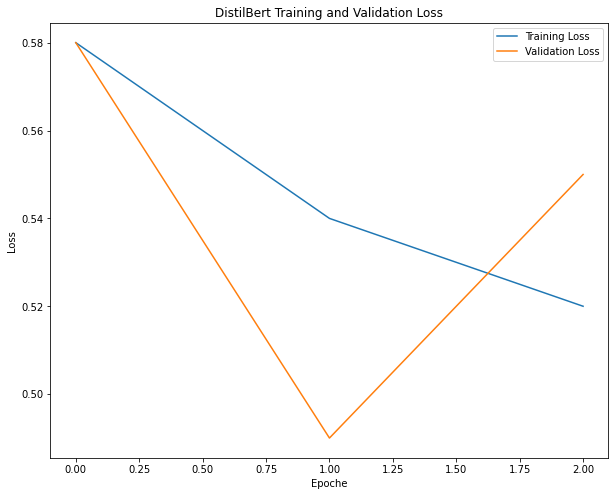

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.plot([0.58, 0.54, 0.52],  label = "Training Loss")
plt.plot([0.58, 0.49, 0.55],  label = "Validation Loss")
#plt.plot([0.73, 0.79, 0.75],  label = "Accuracy")
#plt.plot([0.07, 0.08, 0.08],  label = "Precision")
#plt.plot([0.71, 0.65, 0.70],  label = "Recall")
#plt.plot([0.13, 0.15, 0.14],  label = "F1")
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.title('DistilBert Training and Validation Loss')
plt.legend()
plt.show()

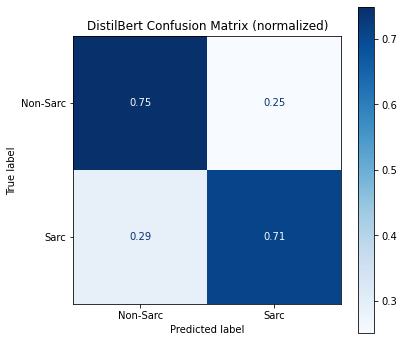

In [ ]:
plot_confusion_matrix(y_preds, tokenized_dataset_small['test']['labels'], ['Non-Sarc', 'Sarc'], normal='true', title='DistilBert Confusion Matrix (normalized)')

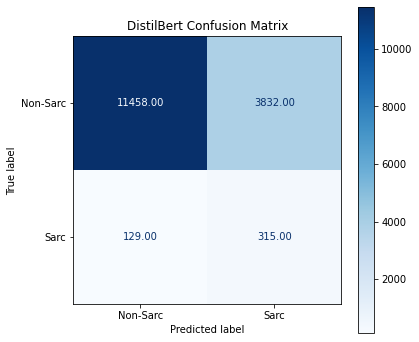

In [ ]:
plot_confusion_matrix(y_preds, tokenized_dataset_small['test']['labels'], ['Non-Sarc', 'Sarc'], normal=None, title='DistilBert Confusion Matrix')

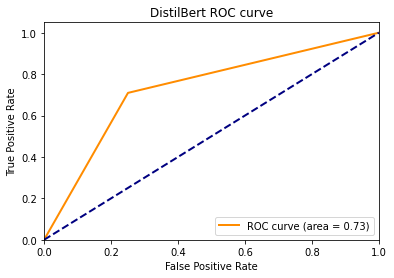

In [ ]:
fpr, tpr, _ = roc_curve(tokenized_dataset_small['test']['labels'], y_preds)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc,title='DistilBert ROC curve')

# MPNet

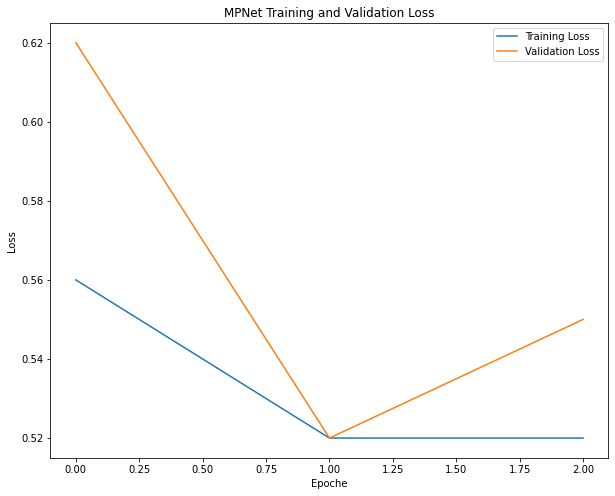

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.plot([0.56, 0.52, 0.52],  label = "Training Loss")
plt.plot([0.62, 0.52, 0.55],  label = "Validation Loss")
#plt.plot([0.72, 0.77, 0.75],  label = "Accuracy")
#plt.plot([0.07, 0.08, 0.08],  label = "Precision")
#plt.plot([0.74, 0.71, 0.71],  label = "Recall")
#plt.plot([0.13, 0.15, 0.15],  label = "F1")
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.title('MPNet Training and Validation Loss')
plt.legend()
plt.show()

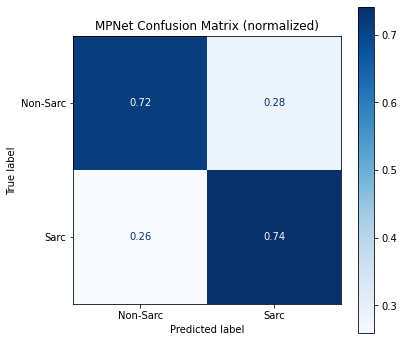

In [ ]:
plot_confusion_matrix(y_preds, tokenized_dataset_small['test']['labels'], ['Non-Sarc', 'Sarc'], normal='true', title='MPNet Confusion Matrix (normalized)')

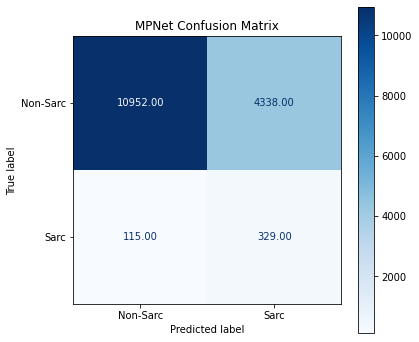

In [ ]:
plot_confusion_matrix(y_preds, tokenized_dataset_small['test']['labels'], ['Non-Sarc', 'Sarc'], normal=None, title='MPNet Confusion Matrix')

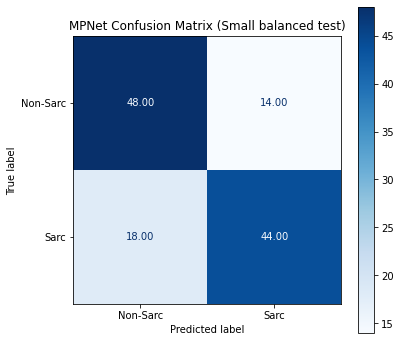

In [ ]:
plot_confusion_matrix(y_preds, tokenized_dataset_small['labels'], ['Non-Sarc', 'Sarc'], normal=None, title='MPNet Confusion Matrix (Small balanced test)')

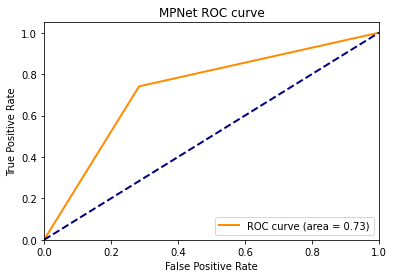

In [ ]:
fpr, tpr, _ = roc_curve(tokenized_dataset_small['test']['labels'], y_preds)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc,title='MPNet ROC curve')

# Look at predictions with highest and lowerst loss.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["labels"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
tokenized_dataset_small.set_format("torch",
                            columns=["input_ids", "attention_mask", "labels"])
# Compute loss values
pred_vs_true = tokenized_dataset_small['test'].map(forward_pass_with_label, batched=True, batch_size=8)

  0%|          | 0/16 [00:00<?, ?ba/s]

In [ ]:
pred_vs_true.set_format("pandas")
cols = ["comment", "labels", "predicted_label", "loss", "subreddit", "parent_id"]
df_test = pred_vs_true[:][cols]

In [ ]:
df_test.sort_values("loss", ascending=False).head(40)

,comment,labels,predicted_label,loss,subreddit,parent_id
10628,"But they earned their money, so it's not OK fo...",0,1,2.749292,politics,1pvgpx
440,"But when you rip off a man's genitals, you gua...",0,1,2.716434,politics,ddh1e4k
8465,But Prez Obama is not at all responsible for t...,0,1,2.710792,politics,19rv31
8267,"but, but those poor Palestinians are just vict...",0,1,2.708518,worldnews,2fx4de
5778,Yeah that'll fix wealth inequality,0,1,2.707524,news,2wt5rr
3789,"But remember, ISIS has nothing to do with Islam!",0,1,2.707434,news,4n4d05
12539,"Yeah, right wingers don't listen to reason or ...",0,1,2.701159,politics,jxy1o
12461,I'm sure he was just standing his ground,0,1,2.699177,news,1m1se2
12906,Wow I bet they're all ultra-conservative with ...,0,1,2.698343,news,44k531
10779,I'm sure the patriarchy is behind this,0,1,2.695157,news,44ahhv


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,comment,labels,predicted_label,loss,subreddit,parent_id
1619,But guys if they get tax cuts then it will hel...,1,1,0.066662,politics,5nt7o6
14807,But it's not terrorism when whites do it!,1,1,0.067059,news,61wdlp
8521,But that can't happen due to our extensive scr...,1,1,0.067862,Conservative,4zry0a
10070,But its unfair for the politician's wallets!,1,1,0.068894,technology,cf2zue1
2556,"But, but, it'll endanger public security!",1,1,0.069150,worldnews,37z0mw
1745,But it has nothing to do with Islam guys!,1,1,0.069826,worldnews,4bgkbt
6683,But you really should trust them because in a ...,1,1,0.070297,worldnews,ctns8gk
5497,Obviously Hitlerally bribed him and this means...,1,1,0.072011,politics,3gxq3t
2871,"Yeah, but, trickle down economics will fix this.",1,1,0.072021,canada,4wa7oq
1182,But I thought Iran was so progressive!,1,1,0.072157,worldnews,652ms2
